# ARIMA model 

**OBJECTIFS:**

1. Charger et visualiser les données.
2. Entraîner nos modèles et faire des prédictions.

**PREAMBULE:**

1. TERMINOLOGIE:
                         
* **AR : < Auto Regressive >** signifie que le modèle utilise la relation dépendante entre une observation et un certain nombre prédéfini d'observations décalées (également appelé "décalage temporel" ou "lag").

* **I:< Integrated >** signifie que le modèle utilise la différenciation des observations brutes (par exemple, il soustrait une observation d'une observation au pas de temps précédent) afin de rendre la série temporelle stationnaire.MA :

* **MA : < Moving Average >** signifie que le modèle exploite la relation entre l'erreur résiduelle et les observations.

2. PARAMETRES DU MODELE :

* **p** est le nombre d'observations du décalage.

* **d** est le degré de différentiation.

* **q** est la taille/largeur de la fenêtre de la moyenne mobile.






## Etape 1: Charger et inspecter les données

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Chargeons maintenant les données de l'action Apple.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Google_Colab_stock_prediction/raw_data/AAPL_5.csv"
df= pd.read_csv(path)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-06-07,24.812500,24.967501,24.740000,24.757500,23.128084,89638000
1,2016-06-08,24.754999,24.889999,24.670000,24.735001,23.107069,83392400
2,2016-06-09,24.625000,24.997499,24.615000,24.912500,23.272882,106405600
3,2016-06-10,24.632500,24.837500,24.620001,24.707500,23.081377,126851600
4,2016-06-13,24.672501,24.780001,24.275000,24.334999,22.733387,152082000


In [ ]:
df.shape

(1258, 7)

In [ ]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

* **Remarque:** Notre target sera la valeur Close.

In [ ]:
y = df.Close

Avant de construire le modèle ARIMA, voyons s'il existe une corrélation croisée dans nos données

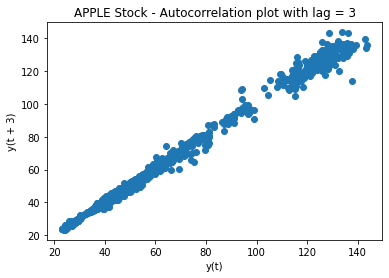

In [ ]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('APPLE Stock - Autocorrelation plot with lag = 3')
plt.show()

Nous pouvons maintenant confirmer que le modèle ARIMA sera un bon modèle à appliquer à ce type de données (il y a une auto-corrélation dans les données).

## Etape 2: Etude de la stationnarité

* **CONTEXTE:** 

Comme nous le voyons dans les paramètres requis par le modèle(cf préambule 2.), l'utilisation des modèles ARIMA requiert que **les séries temporelles soit stationnaire**.
D'où la nécessité de réaliser une étude de stationnarité.

* **TEST DE STATIONNARITE: Augumented Dickey Fuller (ADF) :**

Il s'agit d'un test d’hypothèse permettant de verifier la stationnarité de notre time series:

**H0:** la série temporelle est non stationnaire.

**H1:** la série temporelle est stationnaire.

**Régle de décision:** Ainsi, si la p-value du test est inférieure au seuil de signification (0,05), nous pouvons rejeter l'hypothèse nulle et en déduire que la série chronologique est effectivement stationnaire.
Donc, dans notre cas, si la valeur p-value > 0,05, nous devrons trouver l'ordre de différenciation.

In [ ]:
# ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(y.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.013002128813902185
p-value: 0.9595942352120581


Ainsi, notre serie temporelle est non stationnaire.
Pour la rendre stationnaire nous allons utiliser **la differencing Method**:
* Cela signifie que nous prenons la différence entre chaque valeur et la précédente (première différence).
* L'objectif est de repeter ce processus jusqu'à obtenir l'orde minimum de différentiation dont nous avons besoin pour rendre notre serie temporelle stationnaire 

Nous allons tracer les courbes d'ACF les visualiser, et imprimez leur p-value adfuller pour être sûr

ADF Statistic: 0.013002128813902185
p-value: 0.9595942352120581


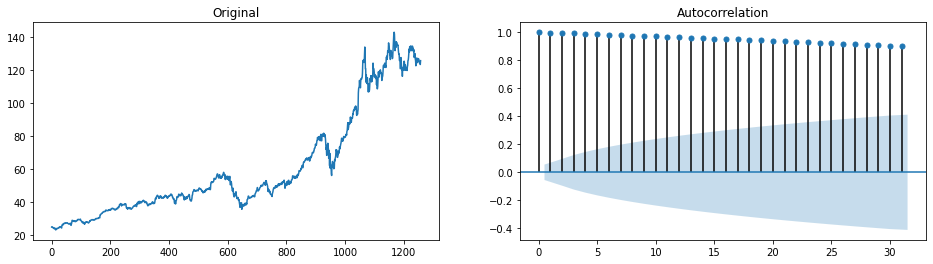

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# ADF Test Original
result = adfuller(y.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(y)
ax1.set_title("Original")
plot_acf(y, ax=ax2);



* **Première Différence**

ADF Statistic: -7.405002341662106
p-value: 7.384394662155277e-11


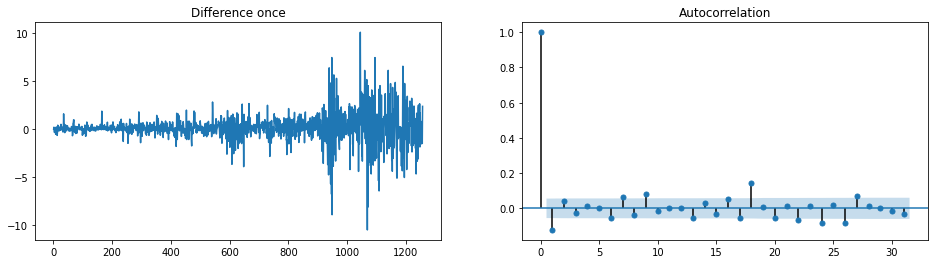

In [ ]:
# ADF Test Première Différence
result = adfuller(y.diff(1).dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Première Différence
diff = y.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

* **Deuxième Différence**

ADF Statistic: -16.011386343970926
p-value: 6.350059758222723e-29


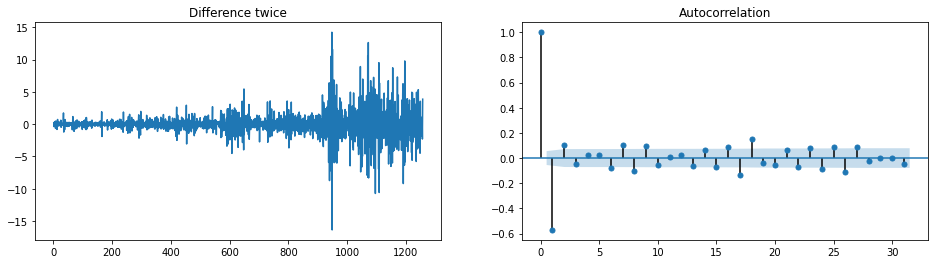

In [ ]:
# ADF Test Deuxième Différence
result = adfuller(y.diff(1).diff(1).dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Deuxième Différence
diff = y.diff(1).diff(1).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);


* **Notre Choix:** 

Ne gardons qu'un seul ordre de diff et nommons cette série y_diff (nous pourrons toujours essayer d'autres diff plus tard).

In [ ]:
y_diff = y.diff().dropna()

## Etape 3: Choix du paramètres ARIMA(p, d, q):

* **Le choix du d :**

Effectuez un test de stationnarité pour différents niveaux de **d** pour estimer le nombre de différences nécessaires pour rendre une série chronologique donnée stationnaire. Sélectionne la valeur maximale **d** pour laquelle la série temporelle est jugée stationnaire par le test statistique.



In [ ]:
!pip install statsmodels

In [ ]:
!pip install pmdarima

In [ ]:
!pip list 

In [ ]:
from pmdarima.arima import auto_arima

ImportError: ignored

* **Le choix du p :**

**p** est l'ordre du terme autorégressif (AR). Il fait référence au nombre de retards à utiliser comme prédicteurs.

Nous pouvons déterminer le nombre requis de termes AR en inspectant le graphique d'autocorrélation partielle (PACF).

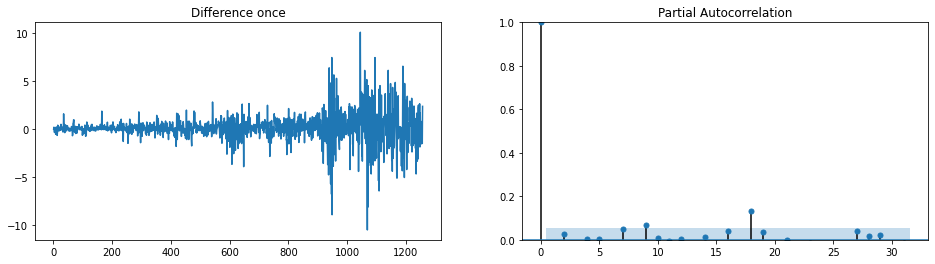

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = y.diff(1).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

* **Le choix du q :**

**q** est l'ordre du terme Moving Average (MA). Il s'agit du nombre d'erreurs de prévision décalées qui doivent être intégrées dans le modèle ARIMA.

Nous pouvons déterminer le nombre requis de termes MA en inspectant le graphique d'autocorrélation (ACF).

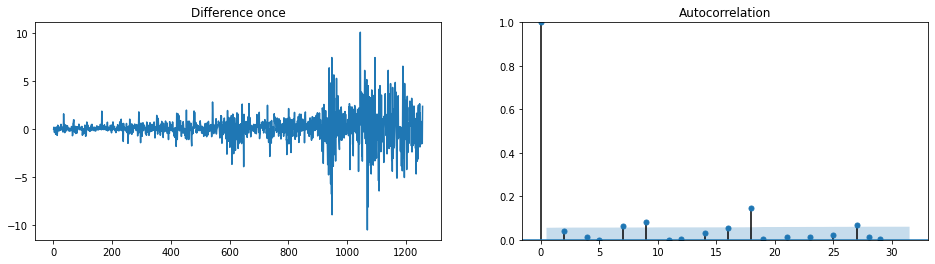

In [ ]:
diff = y.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

Commenter le choix des parametres.... 

## Etape 4: Construire le modèle prédictif ARIMA

* **ARIMA(1,1,1)**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1. initialize the model
arima = ARIMA(y, order=(1, 1, 1))

# 2. fit the models
arima = arima.fit()

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1257
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2253.755
Method:                       css-mle   S.D. of innovations              1.454
Date:                Wed, 09 Jun 2021   AIC                           4515.509
Time:                        03:07:37   BIC                           4536.055
Sample:                             1   HQIC                          4523.231
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0803      0.037      2.143      0.032       0.007       0.154
ar.L1.D.Close    -0.3683      0.203     -1.812      0.070      -0.767       0.030
ma.L1.D.Close     0.2501      0.212      1.181      0.238      -0.165       0.665
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.7155           +0.0000j            2.7155            0.5000
MA.1           -3.9992           +0.0000j            3.9992            0.5000
-----------------------------------------------------------------------------
"""

**REMARQUE(à Améliorer):**
Il semble que les modèles ARIMA (1,1,1) ont moins de chance d'être surajustés (les valeurs p restent faibles) et maintiennent un score AIC quasi similaire à celui des autres modèles.

* **Évaluer les performances du modèle**

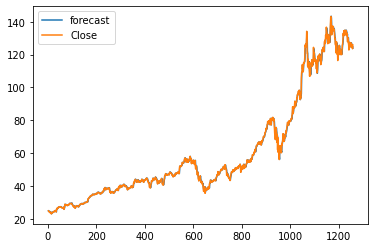

In [ ]:
 # Actual vs Fitted
arima.plot_predict(dynamic=False);

**REMARQUE:**

* **dynamic=False :** Il utilise en fait toutes les valeurs y disponibles afin de prédire y_pred, ce qui fait que notre prédiction ARIMA utilise jusqu'à 𝑦𝑡-1 pour prédire 𝑦𝑡 . 

* En réalité, nous n'avons pas accès à tous les y, surtout si nous voulons prédire plusieurs intervalles dans le futur.


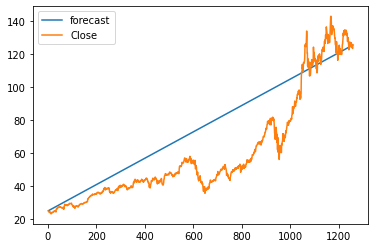

In [ ]:
arima.plot_predict(dynamic= True);

**REMARQUE:**

* **dynamic= True :** Si dynamic est True, les prévisions dans l'échantillon sont utilisées à la place des variables dépendantes décalées. La première valeur de prévision est start.



## Etape 5: Prédiction réelle

Jusqu'à présent notre modèle a vu **toute la série y** pendant la phase d'ajustement ! Pour cette raison, nous allons spliter nos données.

* **TRAIN-TEST-SPLIT :**
Nous divisons les données en un ensemble d'apprentissage (70 %) et un ensemble de test (30 %). 

In [ ]:
y_train = y[0:int(len(df)*0.7)]
y_test = y[int(len(df)*0.7):]
arima = ARIMA(y_train, order=(1, 2, 1)).fit() 

y_train.shape[0], y_test.shape[0]

(880, 378)

* Nous allons utiliser **la méthode .forecast()** sur notre ARIMA.fit() pour "prévoir" les 30% de points de données restant.

In [ ]:
(forecast, stderr, conf_int) = arima.forecast(378, alpha=0.05)

In [ ]:
forecast = pd.Series(forecast, name='forecast')
stderr = pd.Series(stderr)
conf_int = pd.DataFrame(conf_int, columns=['low', 'high'])

* Nous allons representer graphiquement les valeurs prévues ainsi que la fourchette supérieure et inférieure de l'intervalle d'incertitude de 95%.

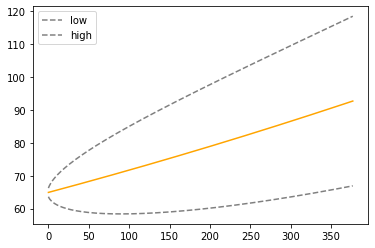

In [ ]:
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='grey', ls='--')
plt.plot(conf_int['high'], label='high', c='grey', ls='--')
plt.legend()

Traçons nos points de données réels des 70% de points de données précédents pour mieux saisir les performances du modèle par rapport au passé.

In [ ]:
forecast.index = y_test.index
conf_int.index = y_test.index

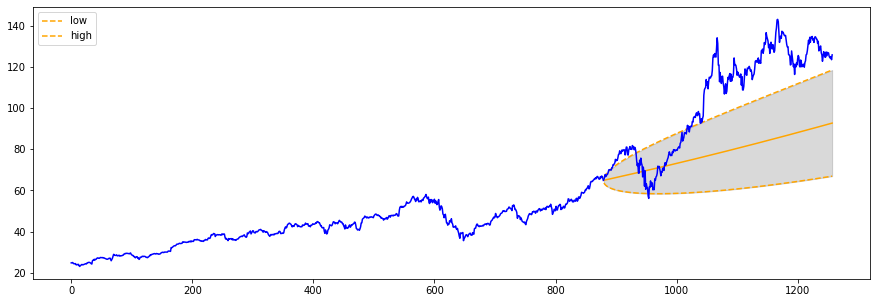

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='orange', ls='--')
plt.plot(conf_int['high'], label='high', c='orange', ls='--')
plt.plot(y_train, c='blue')
plt.plot(y_test, c='blue')
plt.legend()
plt.fill_between(y_test.index, conf_int['low'], conf_int['high'], color='k', alpha=.15)

* **Verification des certaines hypohtèses portant sur les résidus:** 
1. Distribution normale 
2. Moyenne constante 
3. Variance constante
4. Covariance constance 



(<matplotlib.axes._subplots.AxesSubplot at 0x7f027fd0ec10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f027fe90810>)

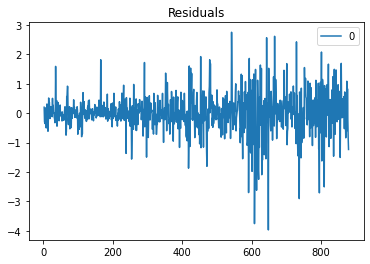

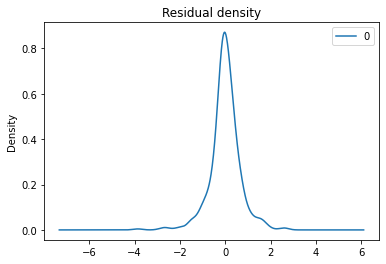

In [ ]:
residuals = pd.DataFrame(arima.resid)
residuals.plot(title="Residuals"), residuals.plot(kind='kde', title='Residual density')

* **Metrics de performances :**

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [ ]:
forecast_accuracy(forecast, y_test)

{'acf1': 0.9873646459638652,
 'corr': 0.9066575466808161,
 'mae': 26.01081662206038,
 'mape': 0.2265469698333943,
 'me': -25.060866163723727,
 'minmax': 0.22566049672021515,
 'mpe': -0.21123754147610216,
 'rmse': 30.647919963628905}

## Etape 6: Grid Search

* **Executons notre propre gridsearch pour trouver nos meilleurs paramètres(p,d,q)**

In [ ]:
import pmdarima as pm

model = pm.auto_arima(y_train, 
                      start_p=0, max_p=3,
                      start_q=0, max_q=3, 
                      d=None,           # let model determine 'd'
                      test='adf',       # using adftest to find optimal 'd'
                      trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

ModuleNotFoundError: ignored

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools

range_p = [0,1,2]
range_d = [1,2]
range_q = [0,1,2]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]
        model = ARIMA(y_train, order=order).fit()
        # y_pred = model.forecast(len(y_test))[0] for unknown reason this crash
        # r2s.append(r2_score(y_pred, y_true))
        orders.append(order)
        aics.append(model.aic)
        
        
df = pd.DataFrame(list(zip(fold_idxs, orders, aics)),#, r2s)), 
                   columns =['Fold', '(p,d,q)', 'AIC'])#, 'R2'])

ValueError: ignored